In [ ]:
import tensorflow as tf
import pandas as pd
import sys
import csv
import glob

tf.compat.v1.disable_v2_behavior()

import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Add, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, BatchNormalization
# regularizers
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from scipy import signal
import openpyxl

In [ ]:
path =r'C:/Users/Smartgrid_ML/Desktop/180315/'
filenames = glob.glob(path + "/*.csv")

files_csv = [f for f in filenames if f[-3:] == 'csv']
files_csv

In [2]:
dataall = np.hstack([load, pv, weather_dat])
index=['Dry bulb F','Dew Point F', 'System Load', 'Measured PV','DHI','DNI','GHI','CS_DHI','CS_DNI','CS_GHI','DP_C','SZ Angle','Surf Albedo','Wind Speed', 'Rel. Humidity']
dataall = np.vstack([index, dataall])
print(dataall.shape)
print(max(dataall[1:,2]))

(78841, 15)
9999.0


In [3]:
df = pd.DataFrame(dataall[1:,:], columns=dataall[0,:])
df.head()

,Dry bulb F,Dew Point F,System Load,Measured PV,DHI,DNI,GHI,CS_DHI,CS_DNI,CS_GHI,DP_C,SZ Angle,Surf Albedo,Wind Speed,Rel. Humidity
0,36.0,29.0,12214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.77,0.866,0.1,100.0
1,36.0,29.0,11573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.7,0.866,0.1,100.0
2,35.0,29.0,11114.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144.23000000000002,0.866,0.1,100.0
3,35.0,30.0,10863.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.525,0.866,0.1,100.0
4,36.0,31.0,10827.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.47500000000001,0.866,0.1,100.0


In [4]:
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)

In [5]:
import seaborn as sns
from keijzer import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Dense, Input, Flatten, Add, concatenate, Dropout, Activation, Multiply
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D  
from tensorflow.keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import math

def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.

class LossHistory(tensorflow.keras.callbacks.Callback):  # history = LossHistory()
    def init(self):  # history.init()
        self.losses = []
        # self.accs = []
        self.val_losses = []
        # self.val_accs = []
        self.rmses = []
        self.mses = []
        self.maes = []
        self.mapes = []
        self.val_rmses = []
        self.val_mses = []
        self.val_maes = []
        self.val_mapes = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        # self.accs.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        # self.val_accs.append(logs.get('val_accuracy
        self.rmses.append(logs.get('root_mean_squared_error'))
        self.mses.append(logs.get('mean_squared_error'))
        self.maes.append(logs.get('mean_absolute_error'))
        self.mapes.append(logs.get('mean_absolute_percentage_error'))
        self.val_rmses.append(logs.get('val_root_mean_squared_error'))
        self.val_mses.append(logs.get('val_mean_squared_error'))
        self.val_maes.append(logs.get('val_mean_absolute_error'))
        self.val_mapes.append(logs.get('val_mean_absolute_percentage_error'))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [6]:
norm_df = np.array(norm_df)
norm_df2 = norm_df[:,(0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14)]
def create_dataset(dataset, timesteps, output_timesteps):
    dataX, dataY = [], []
    for i in range(len(dataset) - timesteps -output_timesteps - 1):
        a = dataset[i:(i + timesteps), :]
        dataX.append(a)
        dataY.append(dataset[(i + timesteps):(i+timesteps+output_timesteps), :])
    return np.array(dataX), np.array(dataY)

timesteps = 24
output_timesteps = 12
X, Y = create_dataset(norm_df2, timesteps, output_timesteps)

print(X.shape)
print(Y.shape)

(78803, 24, 12)
(78803, 12, 12)


In [7]:
trX = X[:47286, :, :]
vaX = X[47286:55170, :, :]
teX = X[55170:, :, :]
trY = Y[:47286, :, 2]
vaY = Y[47286:55170,:, 2]
teY = Y[55170:, :,2]

print(trX.shape)
print(trY.shape)
print(teX.shape)
print(teY.shape)

(47286, 24, 12)
(47286, 12)
(23633, 24, 12)
(23633, 12)


In [8]:
with tf.device('/gpu:0'):
    alpha=1.0
    gamma=1.2
    beta = 1.178511
    num_features = 12
    hfilters = 128
    hkernel_size1 = 2
    hkernel_size2 = 4
    visible1 = Input(shape=(timesteps, num_features))
    per1 = Permute((2,1))(visible1)
    den1a = Dense(timesteps, activation='tanh')(per1)
    den1b = Dense(timesteps, activation='sigmoid')(per1)
    den1 = Multiply()([den1a, den1b])
    per2 = Permute((2,1), name='attention_vec')(den1)
    mul1 = Multiply()([visible1, per2])
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(mul1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res01 = Add()([d1, visible1])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res02 = Add()([d1, res01])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res03 = Add()([d1, res02])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res04 =Add()([d1, res03])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res05 = Add()([d1, res04])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res06 = Add()([d1, res05])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res07 = Add()([d1, res06])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res08 = Add()([d1, res07])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    res09 = Add()([d1, res08])   # (100, 25) (100, 25)
    d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
    d1a = Activation(activations.tanh)(d1)
    d1b = Activation(activations.sigmoid)(d1)
    d1 = Multiply()([d1a, d1b])
    
    res10 = Add()([d1, res09])   # 
    
    print('res10 :', res10.shape)  # (None, 24, 11) 
    
    out = Conv1D(512, 1, padding='same', activation='relu')(res10)   # 256, 11X10=110  
    out = Dropout(0.2)(out)   
    
    out = Conv1D(256, 1, padding='same', activation='relu')(out) # 512,  110X5=550
    out = Dropout(0.2)(out)  
    
    out = GlobalAveragePooling1D()(out) # pool_size=2, strides=1
    
    out = Dense(output_timesteps)(out) 
    model = Model(inputs=[visible1], outputs=[out])
    
    print(model.summary())
    
    model.compile(loss=root_mean_squared_error, optimizer='adam', metrics=[root_mean_squared_error, 'mse', 'mae', 'mape'])
    early_stopping =EarlyStopping(monitor='val_loss', patience=100)
    batch_size = 100
    epochs = 1000

    history = LossHistory()
    history.init()
    
    #hist = model.fit(trX, trY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaX, vaY), callbacks=[history, early_stopping])  # , checkpoint

res10 : (?, 24, 12)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 12)]     0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 12, 24)       0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 12, 24)       600         permute[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12, 24)       600         permute[0][0]                    
__________________________________________________________________________

In [9]:
    %%time
    hist = model.fit(trX, trY, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(vaX, vaY), callbacks=[history, early_stopping])  # , checkpoint

Train on 47286 samples, validate on 7884 samples
Epoch 1/1000
47286/47286 [==============================] - ETA: 0s - loss: 0.0767 - root_mean_squared_error: 0.0767 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0627 - mean_absolute_percentage_error: 2820.8015

C:\Users\Smartgrid_ML\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


47286/47286 [==============================] - 16s 333us/sample - loss: 0.0767 - root_mean_squared_error: 0.0767 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0627 - mean_absolute_percentage_error: 2820.8015 - val_loss: 0.1296 - val_root_mean_squared_error: 0.1296 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1003 - val_mean_absolute_percentage_error: 28.6864
Epoch 2/1000
47286/47286 [==============================] - 12s 256us/sample - loss: 0.0600 - root_mean_squared_error: 0.0600 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0485 - mean_absolute_percentage_error: 2484.3718 - val_loss: 0.1037 - val_root_mean_squared_error: 0.1037 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0783 - val_mean_absolute_percentage_error: 23.9711
Epoch 3/1000
47286/47286 [==============================] - 12s 247us/sample - loss: 0.0553 - root_mean_squared_error: 0.0553 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0444 - mean_absolute_percentage_err

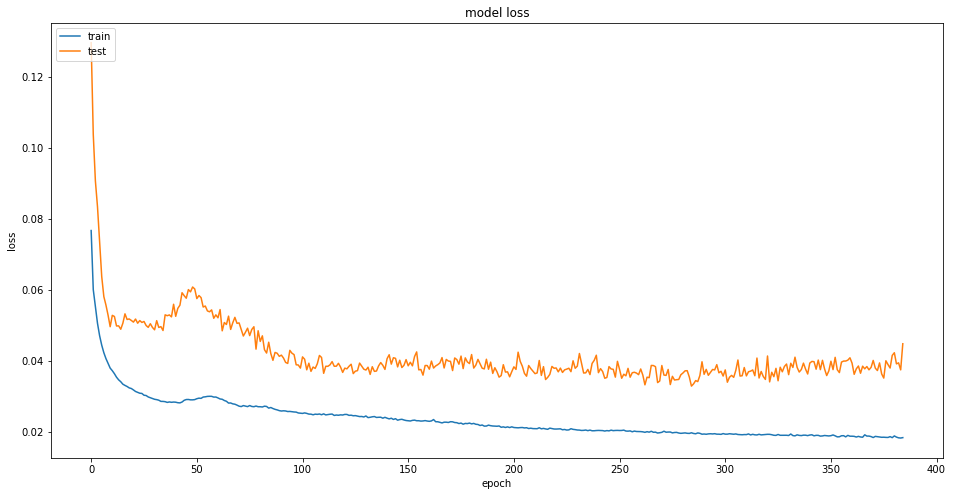

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8)) 
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('FSEFF_TrainingandValidation Loss.png')
plt.show()

#print(get_flops(model))

In [11]:
trainPredict = model.predict(trX, batch_size=batch_size)
validPredict = model.predict(vaX, batch_size=batch_size)
testPredict = model.predict(teX, batch_size=batch_size)

In [12]:
tePredict = testPredict.reshape([-1])
testY = teY.reshape([-1])

np.savetxt('FSEFF_testPredict.txt', tePredict)
 
print('Error Test Score > RMSE == ', np.sqrt(np.mean(np.square(testY-tePredict))), ' MAE == ', mean_absolute_error(testY, tePredict), 'MAPE == ', mean_absolute_percentage_error(testY, tePredict))

Error Test Score > RMSE ==  0.0415548819905407  MAE ==  0.028652365900919782 MAPE ==  10.059522378151447


In [13]:
e_tr = trainPredict - trY
e_va = validPredict - vaY
errors = np.vstack([e_tr,e_va])
prediction = np.vstack([trainPredict,validPredict])
print(errors.shape)
print(prediction.shape)

(55170, 12)
(55170, 12)


In [14]:
dataall = np.hstack([load, pv, weather_dat])
index=['Dry bulb F','Dew Point F', 'System Load', 'Measured PV','DHI','DNI','GHI','CS_DHI','CS_DNI','CS_GHI','DP_C','SZ Angle','Surf Albedo','Wind Speed', 'Rel. Humidity']
dataall = np.vstack([index, dataall])
print(dataall.shape)
print(max(dataall[1:,2]))
df = pd.DataFrame(dataall[1:,:], columns=dataall[0,:])
df.head()
min_max_scaler = preprocessing.MinMaxScaler()
norm_df = pd.DataFrame(min_max_scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)
norm_df2 = norm_df.iloc[:55170, :].copy()
norm_df2.head()

(78841, 15)
9999.0


,Dry bulb F,Dew Point F,System Load,Measured PV,DHI,DNI,GHI,CS_DHI,CS_DNI,CS_GHI,DP_C,SZ Angle,Surf Albedo,Wind Speed,Rel. Humidity
0,0.423423,0.54,0.218118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53211,0.998572,0.994825,0.05,1.0
1,0.423423,0.54,0.185768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53211,0.955240,0.994825,0.05,1.0
2,0.414414,0.54,0.162604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53211,0.887636,0.994825,0.05,1.0
3,0.414414,0.55,0.149937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53211,0.811215,0.994825,0.05,1.0
4,0.423423,0.56,0.148120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53211,0.732332,0.994825,0.05,1.0


In [15]:
norm_df2 = norm_df2.iloc[:,[0, 1, 2, 6, 7, 8, 9, 11, 14]]
norm_df2.head()

,Dry bulb F,Dew Point F,System Load,GHI,CS_DHI,CS_DNI,CS_GHI,SZ Angle,Rel. Humidity
0,0.423423,0.54,0.218118,0.0,0.0,0.0,0.0,0.998572,1.0
1,0.423423,0.54,0.185768,0.0,0.0,0.0,0.0,0.955240,1.0
2,0.414414,0.54,0.162604,0.0,0.0,0.0,0.0,0.887636,1.0
3,0.414414,0.55,0.149937,0.0,0.0,0.0,0.0,0.811215,1.0
4,0.423423,0.56,0.148120,0.0,0.0,0.0,0.0,0.732332,1.0


In [16]:
Prindex = ['Prediction1', 'Prediction2','Prediction3','Prediction4','Prediction5','Prediction6','Prediction7','Prediction8','Prediction9','Prediction10','Prediction11','Prediction12']
Erindex = ['Error1', 'Error2','Error3','Error4','Error5','Error6','Error7','Error8','Error9','Error10','Error11','Error12']

pr_df = pd.DataFrame(prediction, columns=Prindex)
pr_df.head()

,Prediction1,Prediction2,Prediction3,Prediction4,Prediction5,Prediction6,Prediction7,Prediction8,Prediction9,Prediction10,Prediction11,Prediction12
0,0.169020,0.137712,0.122189,0.118383,0.133707,0.177323,0.234318,0.280209,0.311838,0.331228,0.338778,0.339139
1,0.140921,0.119061,0.113558,0.125015,0.160490,0.212971,0.262230,0.296145,0.315739,0.325888,0.327250,0.325607
2,0.118438,0.104404,0.109309,0.138841,0.194397,0.253732,0.293051,0.312592,0.321580,0.326514,0.326027,0.324003
3,0.114201,0.113086,0.136027,0.179226,0.230778,0.275306,0.306741,0.320362,0.322195,0.322296,0.321489,0.325646
4,0.120951,0.141901,0.185098,0.233315,0.273085,0.300678,0.317572,0.322754,0.322108,0.321332,0.321875,0.333675


In [17]:
er_df = pd.DataFrame(errors, columns=Erindex)
er_df.head()

,Error1,Error2,Error3,Error4,Error5,Error6,Error7,Error8,Error9,Error10,Error11,Error12
0,0.004650,0.003419,0.003945,0.005640,0.018289,0.048431,0.078728,0.092321,0.077319,0.049371,0.028861,0.014587
1,0.006628,0.000817,0.000815,0.009598,0.031598,0.057382,0.074342,0.061625,0.033882,0.015971,0.002698,-0.005253
2,0.000194,-0.008339,-0.006108,0.009948,0.038808,0.065844,0.058532,0.030735,0.011664,0.001962,-0.004833,-0.003123
3,0.001458,-0.002332,0.007134,0.023637,0.042890,0.040787,0.024884,0.010445,-0.002357,-0.008565,-0.005637,0.003970
4,0.005534,0.013009,0.029509,0.045427,0.038566,0.018821,0.007655,-0.001798,-0.008753,-0.005794,0.000200,0.004177


In [18]:
norm_df2 = pd.concat([norm_df2, pr_df, er_df],axis=1)
norm_df2.head()

,Dry bulb F,Dew Point F,System Load,GHI,CS_DHI,CS_DNI,CS_GHI,SZ Angle,Rel. Humidity,Prediction1,...,Error3,Error4,Error5,Error6,Error7,Error8,Error9,Error10,Error11,Error12
0,0.423423,0.54,0.218118,0.0,0.0,0.0,0.0,0.998572,1.0,0.169020,...,0.003945,0.005640,0.018289,0.048431,0.078728,0.092321,0.077319,0.049371,0.028861,0.014587
1,0.423423,0.54,0.185768,0.0,0.0,0.0,0.0,0.955240,1.0,0.140921,...,0.000815,0.009598,0.031598,0.057382,0.074342,0.061625,0.033882,0.015971,0.002698,-0.005253
2,0.414414,0.54,0.162604,0.0,0.0,0.0,0.0,0.887636,1.0,0.118438,...,-0.006108,0.009948,0.038808,0.065844,0.058532,0.030735,0.011664,0.001962,-0.004833,-0.003123
3,0.414414,0.55,0.149937,0.0,0.0,0.0,0.0,0.811215,1.0,0.114201,...,0.007134,0.023637,0.042890,0.040787,0.024884,0.010445,-0.002357,-0.008565,-0.005637,0.003970
4,0.423423,0.56,0.148120,0.0,0.0,0.0,0.0,0.732332,1.0,0.120951,...,0.029509,0.045427,0.038566,0.018821,0.007655,-0.001798,-0.008753,-0.005794,0.000200,0.004177


In [19]:
norm_df2 = np.array(norm_df2)
print(norm_df2.shape)
timesteps = 24
output_timesteps = 1
Xe, Ye = create_dataset(norm_df2, timesteps, output_timesteps)
print(Xe.shape)
print(Ye.shape)

(55170, 33)
(55144, 24, 33)
(55144, 1, 33)


In [20]:
trXe = Xe[:50000, :, :]
vaXe = Xe[50000:, :, :]
trYe = Ye[:50000, :, -12:]
vaYe = Ye[50000:, :, -12:]
trYe = trYe.reshape(-1,12)
vaYe = vaYe.reshape(-1,12)
print(trXe.shape)
print(trYe.shape)
print(vaXe.shape)

(50000, 24, 33)
(50000, 12)
(5144, 24, 33)


In [22]:
with tf.device('/gpu:0'):
    def make_model(alpha):
        beta = math.sqrt(2/alpha/1.44)
        hfilters = 128
        hkernel_size1 = 2
        hkernel_size2 = 4
        num_features = 33
        visible1e = Input(shape=(timesteps, num_features))
        per1 = Permute((2,1))(visible1e)
        den1a = Dense(timesteps, activation='tanh')(per1)
        den1b = Dense(timesteps, activation='sigmoid')(per1)
        den1 = Multiply()([den1a, den1b])
        per2 = Permute((2,1), name='attention_vece')(den1)
        mul1 = Multiply()([visible1e, per2])
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=1)(mul1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res01 = Add()([d1, visible1e])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res01)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1)    
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res02 = Add()([d1, res01])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res02) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res03 = Add()([d1, res02])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res03)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)  
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res04 =Add()([d1, res03])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res04)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=32)(d1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res05 = Add()([d1, res04])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=32)(res05) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=16)(d1)   
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res06 = Add()([d1, res05])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=16)(res06) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=8)(d1)
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res07 = Add()([d1, res06])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=8)(res07)  
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=4)(d1) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res08 = Add()([d1, res07])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=4)(res08)   
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=2)(d1)  
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        res09 = Add()([d1, res08])   # (100, 25) (100, 25)
        d1 = Conv1D(filters=round(hfilters*alpha), kernel_size=round(hkernel_size1*beta), padding='causal', dilation_rate=2)(res09) 
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])
        d1 = Conv1D(filters=num_features, kernel_size=round(hkernel_size2*beta), padding='causal', dilation_rate=1)(d1)    
        d1a = Activation(activations.tanh)(d1)
        d1b = Activation(activations.sigmoid)(d1)
        d1 = Multiply()([d1a, d1b])

        res10 = Add()([d1, res09])   # 

        print('res10 :', res10.shape)  # (None, 24, 11) 

        oute = Conv1D(512, 1, padding='same', activation='relu')(res10)   # 256, 11X10=110  
        oute = Dropout(0.2)(oute)   

        oute = Conv1D(256, 1, padding='same', activation='relu')(oute) # 512,  110X5=550
        oute = Dropout(0.2)(oute)  

        oute = GlobalAveragePooling1D()(oute) # pool_size=2, strides=1

        oute = Dense(12)(oute) 
        modele = Model(inputs=[visible1e], outputs=[oute])
        modele.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'accuracy'])
        return modele
    
    alpha_cand = [1.0, 1.05, 1.1, 1.2]
    
    my_classifier = KerasClassifier(make_model, batch_size = 100)
    validator = GridSearchCV(my_classifier, param_grid = {'alpha': alpha_cand, 'epochs' : [200]})
    
    validator.fit(trXe, trYe, verbose=2)
    
    print('The parameters of the best model are: ')
    print(validator.best_params_)

res10 : (?, 24, 33)
Train on 40000 samples
Epoch 1/200
40000/40000 - 12s - loss: 4.5214e-04 - mean_squared_error: 4.5214e-04 - mean_absolute_error: 0.0145 - mean_absolute_percentage_error: 375.0717 - acc: 0.2776
Epoch 2/200
40000/40000 - 12s - loss: 2.0864e-04 - mean_squared_error: 2.0864e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 294.2439 - acc: 0.3434
Epoch 3/200
40000/40000 - 12s - loss: 1.6370e-04 - mean_squared_error: 1.6370e-04 - mean_absolute_error: 0.0094 - mean_absolute_percentage_error: 245.2594 - acc: 0.3811
Epoch 4/200
40000/40000 - 11s - loss: 1.4680e-04 - mean_squared_error: 1.4680e-04 - mean_absolute_error: 0.0089 - mean_absolute_percentage_error: 244.3461 - acc: 0.4032
Epoch 5/200
40000/40000 - 12s - loss: 1.3354e-04 - mean_squared_error: 1.3354e-04 - mean_absolute_error: 0.0085 - mean_absolute_percentage_error: 233.5305 - acc: 0.4225
Epoch 6/200
40000/40000 - 11s - loss: 1.3309e-04 - mean_squared_error: 1.3309e-04 - mean_absolute_error: 0.0085 

C:\Users\Smartgrid_ML\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


res10 : (?, 24, 33)
Train on 40000 samples
Epoch 1/200
40000/40000 - 12s - loss: 4.3160e-04 - mean_squared_error: 4.3160e-04 - mean_absolute_error: 0.0144 - mean_absolute_percentage_error: 339.0738 - acc: 0.2967
Epoch 2/200
40000/40000 - 11s - loss: 2.0012e-04 - mean_squared_error: 2.0012e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 259.1898 - acc: 0.3589
Epoch 3/200
40000/40000 - 11s - loss: 1.6526e-04 - mean_squared_error: 1.6526e-04 - mean_absolute_error: 0.0095 - mean_absolute_percentage_error: 243.4904 - acc: 0.3908
Epoch 4/200
40000/40000 - 11s - loss: 1.4887e-04 - mean_squared_error: 1.4887e-04 - mean_absolute_error: 0.0090 - mean_absolute_percentage_error: 243.5594 - acc: 0.4072
Epoch 5/200
40000/40000 - 11s - loss: 1.3598e-04 - mean_squared_error: 1.3598e-04 - mean_absolute_error: 0.0086 - mean_absolute_percentage_error: 225.9301 - acc: 0.4270
Epoch 6/200
40000/40000 - 11s - loss: 1.3149e-04 - mean_squared_error: 1.3149e-04 - mean_absolute_error: 0.0084 